<a href="https://colab.research.google.com/github/WorldEconomist/Projects/blob/main/Gaming_AB_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1ycWXMBRiKG590geQQBAiZIjbKmWlSoCn

Downloading...
From: https://drive.google.com/uc?id=1ycWXMBRiKG590geQQBAiZIjbKmWlSoCn
To: /content/cookie_cats.csv
100% 2.80M/2.80M [00:00<00:00, 53.0MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from tqdm import tqdm

In [3]:
plt.style.use('dark_background')

The data is about an A/B test with a mobile game, Cookie Cats.

**Version** - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).

**Sum_gamerounds** - The number of game rounds played by the player during the first 14 days after install.

**Retention_1** - Did the player come back and play 1 day after installing?

**retention_7** - Did the player come back and play 7 days after installing?

In [4]:
data = pd.read_csv('/content/cookie_cats.csv')

In [5]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


#EDA and Preprocessing

In [6]:
data = data.rename(columns = {'version':'groups',
                              'sum_gamerounds' : 'rounds_in_14_days',
                              'retention_1' : 'login_day_1',
                              'retention_7' : 'login_day_7'})

In [7]:
data.duplicated(subset = 'userid').sum()

0

In [8]:
data['rounds_in_14_days'].describe()

,rounds_in_14_days
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,49854.000000


<Axes: >

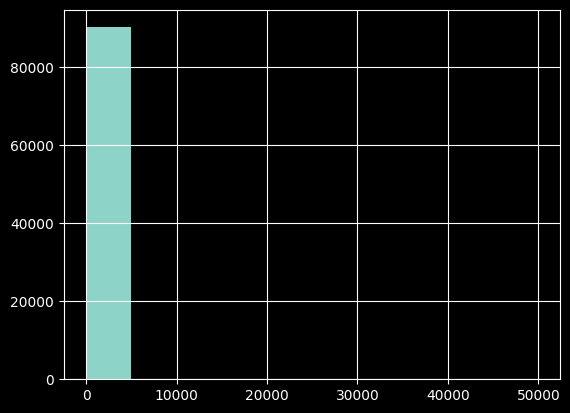

In [9]:
data['rounds_in_14_days'].hist()

In [10]:
data['rounds_in_14_days'].sort_values(ascending = False).head()

,rounds_in_14_days
57702,49854
7912,2961
29417,2640
43671,2438
48188,2294


In [11]:
data = data.drop(data['rounds_in_14_days'].idxmax(), axis = 0)

In [12]:
data['groups'].value_counts(normalize=True)

,proportion
groups,
gate_40,0.50438
gate_30,0.49562


In [13]:
data.groupby('groups')[['rounds_in_14_days',
                        'login_day_1',
                        'login_day_7']].agg({'rounds_in_14_days':['count',
                                                                   'mean',
                                                                   'max',
                                                                   'median'],
                                             'login_day_1':['sum', 'mean'],
                                             'login_day_7':['sum', 'mean']}
                                            ).reset_index()

groups rounds_in_14_days                         login_day_1            \
                       count       mean   max median         sum      mean   
0  gate_30             44699  51.342111  2961   17.0       20034  0.448198   
1  gate_40             45489  51.298776  2640   16.0       20119  0.442283   

  login_day_7            
          sum      mean  
0        8501  0.190183  
1        8279  0.182000

# A/B Testing



We will conduct three A/B tests to evaluate the impact of our changes on rounds played within two weeks and user retention on day-one and day-seven.

##A/B Testing for rounds played

In [14]:
control = data[data['groups'] == 'gate_30']['rounds_in_14_days']
test = data[data['groups'] == 'gate_40']['rounds_in_14_days']

<Axes: >

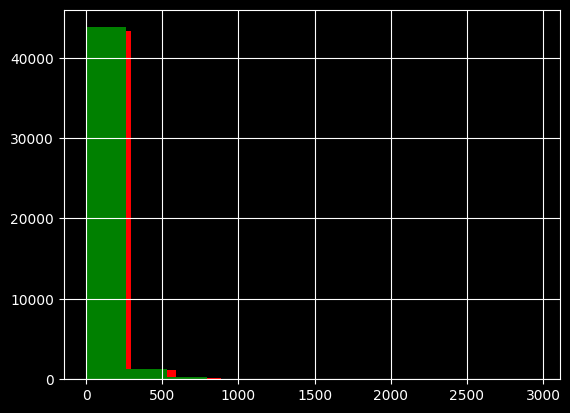

In [15]:
control.hist(color = 'red')
test.hist(color = 'green')

Distribution has a long tail, so for the reference we are going to use a median, instead of a mean.

**H0: There is no difference in the number of "rounds_in_14_days" between the "gate_30" and "gate_40" groups.**

**H1: There is a difference in the number of "rounds_in_14_days" between the "gate_30" and "gate_40" groups.**

Given the large sample size of 40,000+ observations in each group, we can consider decreasing the alpha level from 0.05 to 0.01 to reduce the risk of a Type I error. However, since the two groups are quite similar, maintaining a 0.05 alpha level might be as reasonable.

Let's check whether compared groups have a normal distribution using Q-Q plot, so we can decide whick stat tests we are to use.

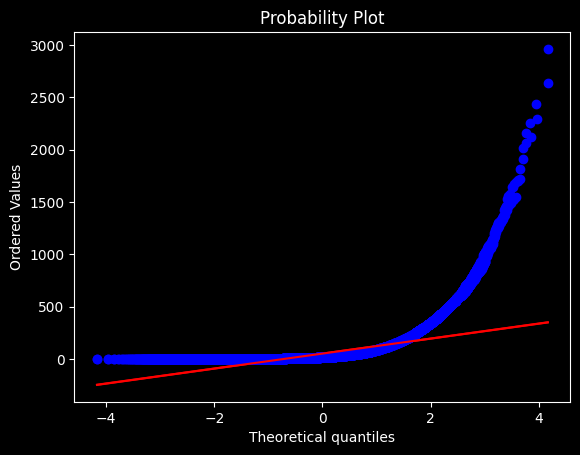

In [16]:
stats.probplot(control,
               dist="norm",
               plot=pylab),

stats.probplot(test,
               dist="norm",
               plot=pylab)
pylab.show()

Given the **non-normal distribution** of the data and the presence of zero values, a parametric test like the t-test is inappropriate. A non-parametric alternative is necessary.** The Mann-Whitney U test** is suitable because it compares the medians of two independent groups, assuming **similar distributions.**


Visual inspection suggests that the variances of the control and test groups are approximately equal. To confirm this, **a Levene test** can be conducted just in case.

In [17]:
levene_pval = stats.levene(control,test)[1]
levene_pval

0.7840494387892463

Variance Homogeneity H0 with 0.78 p-value is not rejected

In [18]:
statistic, p_val = stats.mannwhitneyu(control,
                                      test,
                                      alternative = 'two-sided')

In [19]:
p_val

0.05089155279145376

Based on Mann-Whitney p-value of *0.05089155279145376* **we fail to reject the null hypothesis**. This suggests that the observed difference between the groups is not statistically significant and could be due to chance.

###**The increase of gate level did not affect the amount of rounds played.**

##A/B Testing for Day 1 Conversion

**H0: There is no difference in day 1 retention rate**

**H1: There is a difference in day 1 retention rate**

Given the binary nature of day 1 retention estimator, a **proportion z-test** can be used to compare the proportions of retention between the two groups. Additionally, an **independent t-test** can be applied to the raw retention data if the assumptions of normality and equal variances are met. To provide a more robust analysis, bootstrapping can be employed.

We know that the Homogeneity of variance is already met, as it is visually seen on the hist below.

In [20]:
def bootstrap(A, B, prob_a, prob_b, size, n):
    result = []
    prop = len(B)/len(A)

    for _ in tqdm(range(n)):

      a = np.random.binomial(1,
                             prob_a,
                             size = size).mean()

      b = np.random.binomial(1,
                             prob_b,
                             size = int(round(size*prop, 0))).mean()

      result.append((a, b))
    return result

In [21]:
control = data[data['groups'] == 'gate_30']['login_day_1']
test = data[data['groups'] == 'gate_40']['login_day_1']

100%|██████████| 10000/10000 [00:36<00:00, 273.05it/s]


array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'B'}>]],
      dtype=object)

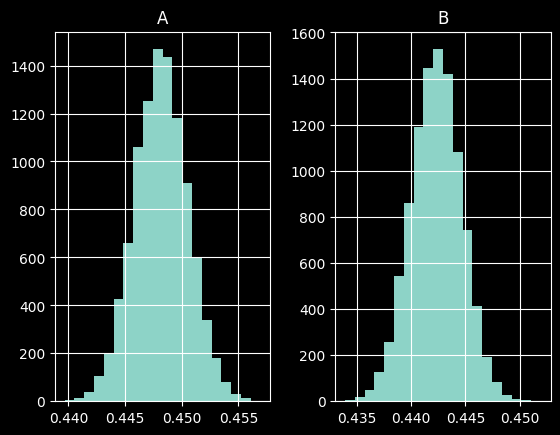

In [22]:
result = pd.DataFrame(bootstrap(control,
                                test,
                                control.mean(),
                                test.mean(),
                                len(control),
                                10000),
                      columns = ['A', 'B'])
result.hist(bins=20)

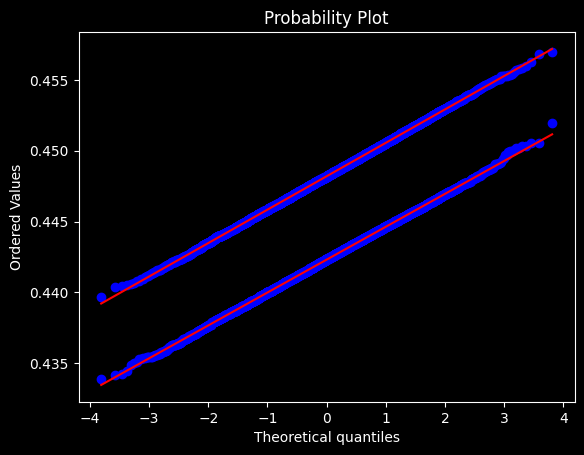

In [23]:
stats.probplot(result['A'],
               dist="norm",
               plot=pylab),

stats.probplot(result['B'],
               dist="norm",
               plot=pylab)
pylab.show()

Distrubution is normal so we can, without a doubt, use T-test here.

In [24]:
np.mean(result['A']>result['B'])

0.9615

In [25]:
_, pval_tt = stats.ttest_ind(a=control,
                             b=test,
                             equal_var = True,
                             alternative = 'two-sided')
pval_tt

0.07392220630182521

In [26]:
stat, pval_ztest = proportions_ztest([control.sum(), test.sum()],
                                     [len(control), len(test)])
pval_ztest

0.0739207603418346

**We fail to reject the null hypothesis** with p value = 0.074. There is no statistically significant difference in day 1 retention rates between the control and test groups based both on the **independent t-test** and **proportion z test**.

Based on the bootstrapping we can conclude that based on our observations **gate_30 will more likely bring in a higher conversion rate** in long_term.

##A/B Testing for Day 7 Conversion

**H0: There is no difference in day 7 retention rate**

**H1: There is a difference in day 7 retention rate**

Given the binary nature of day 1 retention estimator, a **proportion z-test** can be used to compare the proportions of retention between the two groups. Additionally, an **independent t-test** can be applied to the raw retention data if the assumptions of normality and equal variances are met. To provide a more robust analysis, bootstrapping can be employed.

We know that the Homogeneity of variance is already met, as it is visually seen on the hist below.

In [27]:
control = data[data['groups'] == 'gate_30']['login_day_7']
test = data[data['groups'] == 'gate_40']['login_day_7']

100%|██████████| 10000/10000 [00:21<00:00, 461.94it/s]


array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'B'}>]],
      dtype=object)

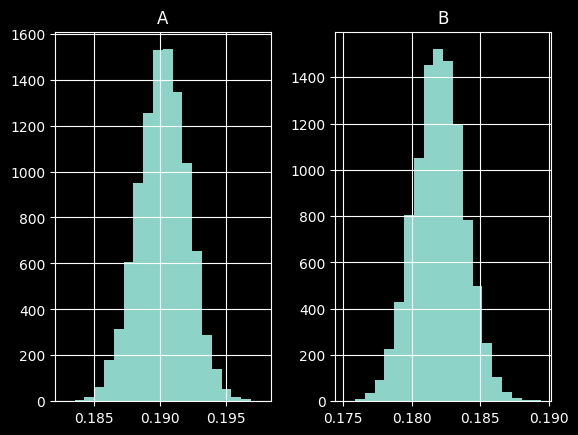

In [28]:
result = pd.DataFrame(bootstrap(control,
                                test,
                                control.mean(),
                                test.mean(),
                                len(control),
                                10000),
                      columns = ['A', 'B'])
result.hist(bins=20)

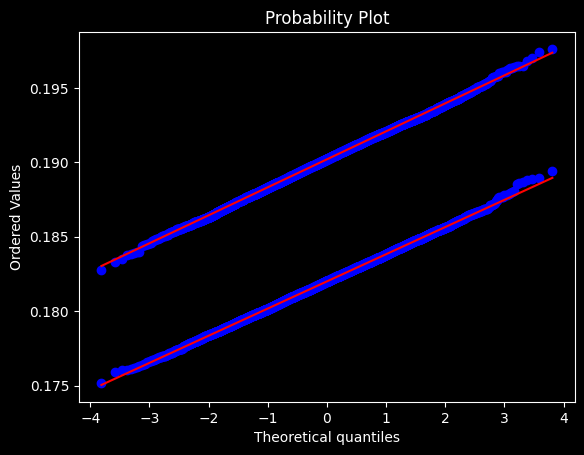

In [29]:
stats.probplot(result['A'],
               dist="norm",
               plot=pylab),

stats.probplot(result['B'],
               dist="norm",
               plot=pylab)
pylab.show()

Distrubution is normal so we can, without a doubt, use T-test here too.

In [30]:
_, pval_tt = stats.ttest_ind(a=control,
                             b=test,
                             equal_var = True,
                             alternative = 'two-sided')
pval_tt

0.0015915357297854773

In [31]:
from statsmodels.stats.proportion import proportions_ztest
stat, pval_ztest = proportions_ztest([control.sum(), test.sum()],
                                      [len(control), len(test)])
pval_ztest

0.0015917731773993442

In [32]:
np.mean(result['A']>result['B'])

0.999

At a significance level = 0.05 with p value = 0.00159, **we reject the null hypothesis**. There is a statistically significant difference in day 7 retention rates between the control and test groups based both on the independent t-test and proportion z-test.

Based on the bootstrapping we can conclude that based on our observations gate_30 will more likely bring in a higher conversion rate in long_term.

#Conclusion

The A/B test comparing A (gate_30) and B (gate_40) revealed the following insights:

*  **Rounds played in 14 days**: The observed difference between the groups is not statistically significant and could be due to chance. The increase of gate level did not affect the amount of rounds played.
*   **1-Day Retention**: There was no statistically significant difference in 1-day retention rates between A and B (p-value = 0.0739). This indicates that both versions perform similarly in terms of short-term user engagement.
*   **7-Day Retention**: A statistically significant difference was observed in 7-day retention rates (p-value = 0.0016). A (gate_30) demonstrated a higher long-term retention rate compared to B (gate_40).

Bootstrapping shows that gate_30 is more likely to have better day 1 and day 7 retention rate than gate_40.

## It is not recommended to upgrade Gate up to level 40.


